In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import display, HTML, Image

import sys
import os
BASE_DIR = os.getcwd().split('xnn4rad-pet')[0] + 'xnn4rad-pet/'
sys.path.append(BASE_DIR)

from collections import defaultdict
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.python.keras.datasets.cifar import load_batch
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import colors
import seaborn as sns
from codebase.bnn_utils import predict
#, bayes_grad, bayes_grad_squared, predict_vis
# from codebase.mc_dropout_vgg import VGGDrop, predict, bayes_grad, bayes_grad_squared, predict_vis, bayes_grad_percentile

import codebase.visualization_utils as vu
import codebase.evaluation_utils as eu
# import codebase.cnn as cnn
# import codebase.data_utils as du
import codebase.pet_eval_utils as peu
import codebase.evaluation_utils as eu
from codebase import custom_metrics as cm

from codebase.data_utils_pet import load_dataset 
from codebase.vanilla_gradients import VanillaGradients
from codebase.bayesgrad import BayesGrad
# from codebase.vanilla_gradients import VanillaGradients
from datetime import datetime
from functools import partial
from codebase.auc import AUC
from scipy.special import expit
from codebase.smoothgrad import SmoothGrad
import json

from joblib import load, dump


physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import sklearn
print('keras:', keras.__version__)
print('tensorflow:', tf.__version__)
print('sklearn:', sklearn.__version__)
print('seaborn:', sns.__version__)

keras: 2.4.0
tensorflow: 2.3.0
sklearn: 0.24.1
seaborn: 0.11.1


In [4]:
from platform import python_version
python_version()

'3.6.9'

In [2]:
vessel_mask = pd.read_csv('../masks/polar_map_mask_20_cart_final.csv', header=None)
vessel_mask = vessel_mask.values

# Load performance evaluations over 20 model retrainings
- Examine mean and st accuracy, ece, auc for Bayesian and deterministic models
- Results saved in xnn4rad-pet/output/performance/bayesian.csv and xnn4rad-pet/output/performance/deterministic.csv were generated by evaluate_performance.py

In [6]:
!ls ../output/performance/

bayesian.csv  bayesian_probs  deterministic.csv  deterministic_probs


In [7]:
basepath = '../output/performance/'
bayesian = pd.read_csv(basepath + 'bayesian.csv', index_col=0)
deterministic = pd.read_csv(basepath + 'deterministic.csv',index_col=0)

In [8]:
# bayesian
print("Bayesian Mean\n")
print(bayesian.mean(axis=0))
print("\nBayesian STD\n")
print(bayesian.std(axis=0))

Bayesian Mean

accuracy    0.884206
ece         0.021688
auc         0.953579
dtype: float64

Bayesian STD

accuracy    0.013398
ece         0.006938
auc         0.002772
dtype: float64


In [9]:
# deterministic
print("Deterministic Mean\n")
print(deterministic.mean(axis=0))
print("\nDeterministic STD\n")
print(deterministic.std(axis=0))

Deterministic Mean

accuracy    0.895223
ece         0.039579
auc         0.953038
dtype: float64

Deterministic STD

accuracy    0.006363
ece         0.008287
auc         0.003055
dtype: float64


# Compare distributuion of probabilities associated with false negativies and false positives for deterministic and bayesian models

In [10]:
X, y_loc = peu.load_data_for_smaps(split='test', data_path='../data')

In [11]:

probs_b = []
for i in range(20):
    base_dir = '../output/performance/bayesian_probs'
    probs_path = os.path.join(base_dir, f'probs{i}.csv')
    probs = pd.read_csv(probs_path, index_col=0)
    probs_b.append(probs.values.reshape(-1,))
probs_b = np.array(probs_b)

probs_d = []
for i in range(20):
    base_dir = '../output/performance/deterministic_probs/'
    probs_path = os.path.join(base_dir, f'probs{i}.csv')
    probs = pd.read_csv(probs_path, index_col=0)
    probs_d.append(probs.values.reshape(-1,))
probs_d = np.array(probs_d)

In [13]:
probs_b.shape

(20, 649)

In [14]:
def dist_plot_with_confidence(probs, abnormal, error_type='fp', ax=None, range_=None, bins=None):
    """
    probs : np.array
        Array of shape (num_trials, num_scans) with predicted probabilities of abnormal
        for each scan in num_scans, for each instance of model retraining in num_trials
    
    abnormal : pd.Series
        Truth labels for normal/abnormal corresponding to each prediction in probs. Shape
        is (num_scans,)
        
    error_type : str
        Valid values include 'fp' for false positive and 'fn' for false negative, or None
        for all examples.
        
    range : (int, int) tuple
        Range defines the edges of the histogram. Defaults to (0, .5) for false negative
        and (0.5, 1.0) for false positive
        
    bins : int
        Number of bins to include in the histogram. Defaults to 5 for false positive or 
        false negative and 10 for all examples.
    
    Plot histogram with confidence intervals for the distribution of predicted probabilities 
    output by a model for specific error types (i.e. false positives, false negatives)
    
    """
    counts = []
    
    # Histigram showing num false positive in prob bin
    for prob in probs:
        pred = (prob > 0.5).astype(int)
        
        if error_type == 'fp':
            mask = (pred == 1) & (abnormal == 0)
            if not range_:
                range_ = (0.5, 1)
            if not bins:
                bins = 5
            prob = prob[mask]
        elif error_type == 'fn':
            mask = (pred == 0) & (abnormal == 1)
            if not range_:
                range_ = (0, 0.5)
            if not bins:
                bins = 5
            prob = prob[mask]
        else:
            if not range_:
                range_ = (0,1)
            if not bins:
                bins = 10

        count, edges = np.histogram(prob, bins=bins, range=range_)
        counts.append(count)
        
    counts = np.array(counts)
    counts_mean = counts.mean(axis=0)
    counts_std = counts.std(axis=0)


    print()

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,3))
    
    X_axis = (edges - 0.05)[1:]
    ax.set_xticks(edges)
    
    x_labels = ["{:0.1f}".format(edge) for edge in edges]
    ax.set_xticklabels(x_labels, rotation=30, ha='center')
    
    
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y')
    
    ax.bar(X_axis, counts_mean, 0.1, edgecolor='black')
    ax.errorbar(X_axis, counts_mean, yerr=counts_std, fmt='none', color='black')
    
    
abnormal = (y_loc.apply(sum, axis=1) != 0).astype(int)
# dist_plot_with_confidence(probs_d, abnormal, error_type='fp')

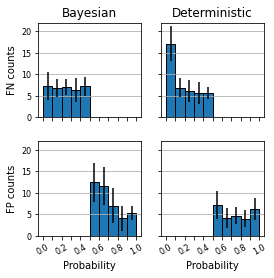

In [15]:
fig, ax = plt.subplots(2,2, figsize=(4, (4/2)*2), sharex=True, sharey=True)

ax[0][0].set_ylim(0,20)

dist_plot_with_confidence(probs_b, abnormal, error_type='fn', ax=ax[0][0], range_=(0,1), bins=10)

pad = 5 # in point

fontsize=10
ax[0][0].set_title('Bayesian', size=12)
ax[0][1].set_title('Deterministic', size=12)

dist_plot_with_confidence(probs_d, abnormal, error_type='fn', ax=ax[0][1], range_=(0,1), bins=10)

fontsize=10
ax[0][0].set_ylabel('FN counts', size=fontsize)
ax[1][0].set_ylabel('FP counts', size=fontsize)
ax[1][1].set_xlabel('Probability', size=fontsize)
ax[1][0].set_xlabel('Probability', size=fontsize)

dist_plot_with_confidence(probs_b, abnormal, error_type='fp', ax=ax[1][0], range_=(0,1), bins=10)

dist_plot_with_confidence(probs_d, abnormal, error_type='fp', ax=ax[1][1], range_=(0,1), bins=10)
ax[1][1].set_yticks(np.arange(0, 23, 5))

# plt.suptitle("Predicted Probabilities for Incorrect Predictions")
fig.tight_layout()
fontsize=8
plt.xticks(fontsize=fontsize)


ax[0][0].set_ylim(0,22)
ax[0][0].set_yticklabels(ax[0][0].get_yticklabels(), fontsize=fontsize)
ax[1][0].set_yticklabels(ax[1][0].get_yticklabels(), fontsize=fontsize)
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), fontsize=fontsize)
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), fontsize=fontsize)

# ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), fontsize=fontsize)
for label in ax[1][1].xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
for label in ax[1][0].xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
# plt.savefig('../output/figures/incorrect_classification_hist_comp_std.png',
#             bbox_inches='tight',
#             dpi=300)

# Load and display saved attention maps for a single model

In [18]:
methods = ['BG_VAR']
split = 'validation'
base_path = '../output/smaps_original'
model_alias = 'norm_abn_VGGDrop_abnormal_lr=0.0001_drop=0.3_reg=0.0_base_filters=128.0_stdscaler=0.0_vary=False_rotation=180.0_hflip=True_vflip=True_hshift=0.05_wshift=0.05_str_rst'

### Train

In [ ]:
split = 'train'
res = peu.load_saved_smaps(methods, split, base_path, model_alias)
s_maps, study_nos, probabilities = res['s_maps'], res['study_nos'], res['probabilities']
X, y_loc = peu.load_data_for_smaps(split, '../data')

peu.display_saliency_maps(s_maps,
                          polar_plots=X,
                          y_loc=y_loc,
                          probabilities=probabilities,
                          k=None,
                          method='BG_VAR',
                          study_nos=study_nos,
                          weighted=False)

### Validation

In [ ]:
split = 'validation'
res = peu.load_saved_smaps(methods, split, base_path, model_alias)
s_maps, study_nos, probabilities = res['s_maps'], res['study_nos'], res['probabilities']
X, y_loc = peu.load_data_for_smaps(split, '../data')


peu.display_saliency_maps(s_maps,
                          polar_plots=X,
                          y_loc=y_loc,
                          probabilities=probabilities,
                          k=None,
                          method='BG_VAR',
                          study_nos=study_nos,
                          weighted=False)

### Test

In [ ]:
split = 'test'
res = peu.load_saved_smaps(methods, split, base_path, model_alias)
s_maps, study_nos, probabilities = res['s_maps'], res['study_nos'], res['probabilities']
X, y_loc = peu.load_data_for_smaps(split, '../data')

peu.display_saliency_maps(s_maps,
                          polar_plots=X,
                          y_loc=y_loc,
                          probabilities=probabilities,
                          k=None,
                          method='BG_VAR',
                          study_nos=study_nos,
                          weighted=False)

# Avg Polar Maps by Region (NOT saliency maps)

In [24]:
methods = ['BG_VAR']
split = 'train'
base_path = '../output/smaps_original'
model_alias = 'norm_abn_VGGDrop_abnormal_lr=0.0001_drop=0.3_reg=0.0_base_filters=128.0_stdscaler=0.0_vary=False_rotation=180.0_hflip=True_vflip=True_hshift=0.05_wshift=0.05_str_rst'

res = peu.load_saved_smaps(methods, split, base_path, model_alias)
s_maps, study_nos, probabilities = res['s_maps'], res['study_nos'], res['probabilities']
X, y_loc = peu.load_data_for_smaps(split, '../data')

Examine differences in rest and stress channels

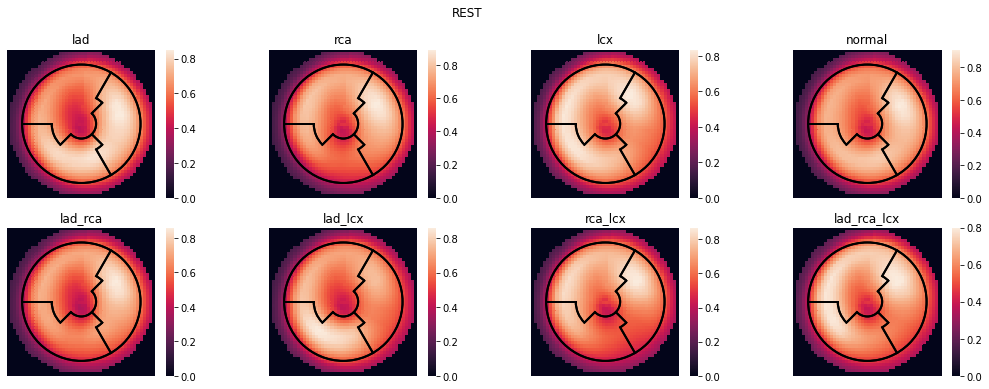

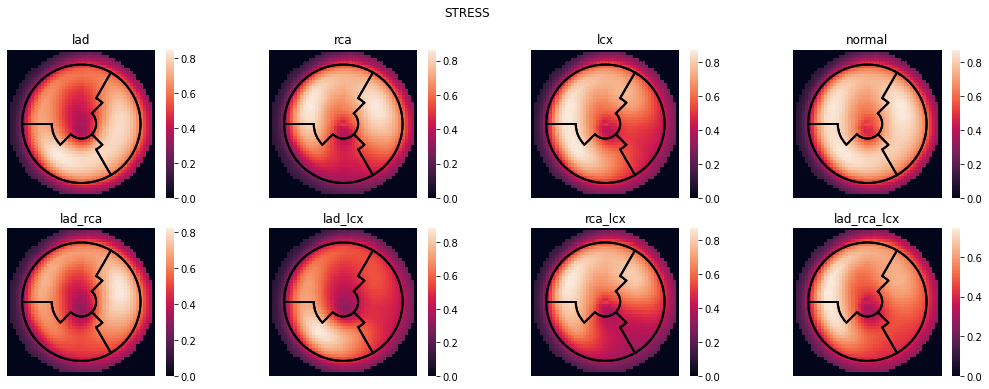

In [25]:
# Train
maps = {'stress': X[:,:,:,0],
        'rest': X[:,:,:,1]}

avg_pmaps = peu.mean_maps(maps, y_loc, ['rest', 'stress'], probabilities=None, counts=False)
peu.plot_avg_maps(avg_pmaps, normalized=True, title_prefix=None, counts=None)

# Avg Attention maps from a single model

In [45]:
list(avg_smaps.keys())

['BG_VAR', 'hellp']

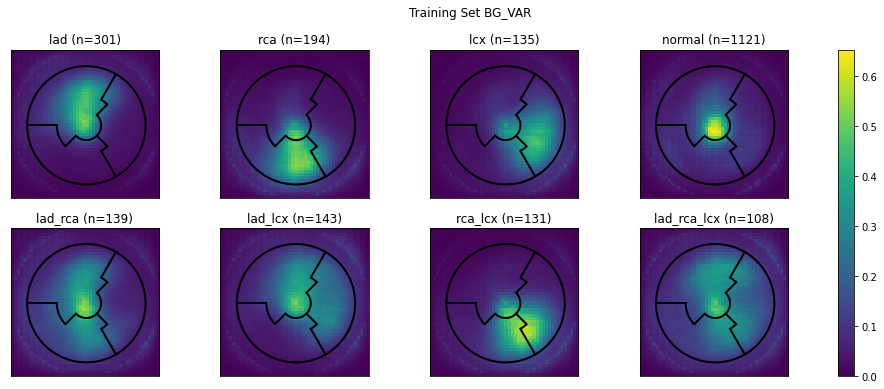

In [10]:
methods = ['BG_VAR']
split = 'train'
base_path = '../output/smaps_original'
model_alias = 'norm_abn_VGGDrop_abnormal_lr=0.0001_drop=0.3_reg=0.0_base_filters=128.0_stdscaler=0.0_vary=False_rotation=180.0_hflip=True_vflip=True_hshift=0.05_wshift=0.05_str_rst'

res = peu.load_saved_smaps(methods, split, base_path, model_alias)
s_maps, study_nos, probabilities = res['s_maps'], res['study_nos'], res['probabilities']
X, y_loc = peu.load_data_for_smaps(split, '../data')

avg_smaps, counts = peu.mean_maps(s_maps,
                       y_loc,
                       ['BG_VAR'],
                       probabilities,
                       counts=True)
peu.plot_avg_maps(avg_smaps,
               normalized=True,
               title_prefix='Training Set',
               counts=counts)

### Validation Set

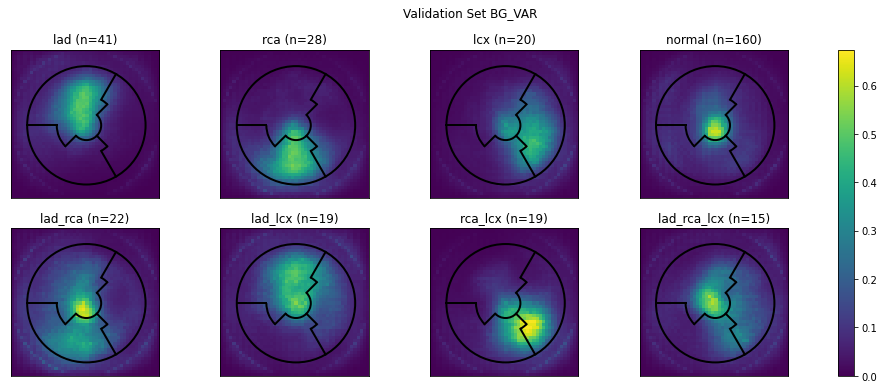

In [11]:
methods = ['BG_VAR']
split = 'validation'
base_path = '../output/smaps_original'
model_alias = 'norm_abn_VGGDrop_abnormal_lr=0.0001_drop=0.3_reg=0.0_base_filters=128.0_stdscaler=0.0_vary=False_rotation=180.0_hflip=True_vflip=True_hshift=0.05_wshift=0.05_str_rst'

res = peu.load_saved_smaps(methods, split, base_path, model_alias)
s_maps, study_nos, probabilities = res['s_maps'], res['study_nos'], res['probabilities']
X, y_loc = peu.load_data_for_smaps(split, '../data')



avg_smaps, counts = peu.mean_maps(s_maps,
                       y_loc,
                       ['BG_VAR'],
                       probabilities,
                       counts=True)
peu.plot_avg_maps(avg_smaps,
               normalized=True,
               title_prefix='Validation Set',
               counts=counts)

### Test set (Figure 8)

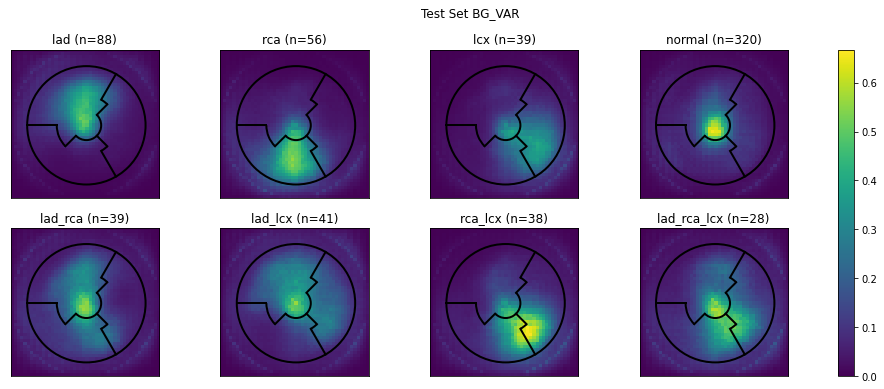

In [71]:
methods = ['BG_VAR']
split = 'test'
base_path = '../output/smaps_original'
model_alias = 'norm_abn_VGGDrop_abnormal_lr=0.0001_drop=0.3_reg=0.0_base_filters=128.0_stdscaler=0.0_vary=False_rotation=180.0_hflip=True_vflip=True_hshift=0.05_wshift=0.05_str_rst'

res = peu.load_saved_smaps(methods, split, base_path, model_alias)
s_maps, study_nos, probabilities = res['s_maps'], res['study_nos'], res['probabilities']
X, y_loc = peu.load_data_for_smaps(split, '../data')



avg_smaps, counts = peu.mean_maps(s_maps,
                       y_loc,
                       ['BG_VAR'],
                       probabilities,
                       counts=True)


peu.plot_avg_maps(avg_smaps,
               normalized=True,
               title_prefix='Test Set',
               counts=counts,
               savepath='../output/figures/avg_smaps_BG_VAR_test_set.png')

# Localization for single vessel disease

1. Train and save 20 dummy classifiers for each baseline method
2. Calculate and save CSVs with baseline performance comparisons over 20 model retrainings. Baseline performance comparisons include
    - Dummy classifier that always predicts LAD, the region with the largest area
    - Dummy classifier with stratified prediction strategy 
    - Supervised CNN trained for localization of normal/abnormal to each vessel territory
3. Calculate and save CSVs with top K prediction localization performance derived from attention maps


In [30]:
X_train, y_loc_train = peu.load_data_for_smaps('train', '../data')

### Save trained dummy classifiers

In [31]:
!mkdir -p ../output/trained_models/loc_largest_area_20_trials
!mkdir -p ../output/trained_models/loc_stratified_20_trials

In [32]:
from joblib import dump, load
from sklearn.dummy import DummyClassifier


# Get examples with single vessel disease
isch = y_loc_train.values[:,3:]
scar = y_loc_train.values[:,:3]
isch, scar = isch.astype(bool), scar.astype(bool)
svd = (isch | scar).sum(axis=1) == 1
y_abn_loc = (isch | scar)
y_enc = np.argmax(y_abn_loc, axis=1)


# Save dummy classifiers with the largest area baseline comparison method
# (i.e. always predict LAD because this region has the largest area)
base_path = '../output/trained_models/loc_largest_area_20_trials'
for i in range(1, 21):
    trial_name = f"norm_abn_loc{i}.joblib"
    
    dc = DummyClassifier(strategy='constant', constant=0)
    dc.fit(X_train, y_enc)
    saved_model_path = os.path.join(base_path, trial_name)
    dump(dc, saved_model_path)

# Save dummy classifiers with the stratified baseline comparison method
base_path = '../output/trained_models/loc_stratified_20_trials'
for i in range(1, 21):
    trial_name = f"norm_abn_loc{i}.joblib"    
    dc = DummyClassifier(strategy='stratified')
    dc.fit(X_train, y_enc)
    saved_model_path = os.path.join(base_path, trial_name)
    dump(dc, saved_model_path)

## Get baseline performance dataframes over 20 trials

Create csvs containing performance for the baseline methods -- fully supervised localization, and dummy prediction strategies (stratified, largest area) -- for examples with single vessel disease. This will create the following files:

- largest_area_loc_f1.csv
- largest_area_loc_precision.csv
- largest_area_loc_recall.csv
- stratified_loc_f1.csv		
- stratified_loc_precision.csv
- stratified_loc_recall.csv	
- supervised_loc_recall.csv
- supervised_loc_precision.csv
- supervised_loc_f1.csv

Each file contains the 20 rows, one for each trial/model retraining, and 4 columns. The columns contain performance according to the given metric within each vessel territory as well as a macro average of the given metric across all territories. 







In [91]:
X, y_loc = peu.load_data_for_smaps('test', '../data')

In [9]:
import scipy

def prec_by_vessel(preds, labels, vessel='lad'):
    true_positive = (preds[preds == vessel] == labels[preds == vessel]).sum()
    predicted_positive = (preds[preds == vessel]).shape[0]
    
    precision = (true_positive / predicted_positive)
    precision = np.nan_to_num(precision)
    return precision

def recall_by_vessel(preds, labels, vessel='lad'):
    true_positive = (preds[preds == vessel] == labels[preds == vessel]).sum()
    all_positive = (labels[labels == vessel]).shape[0]
    
    return(true_positive / all_positive)

def f1_by_vessel(preds, labels, vessel='lad'):
    precision = prec_by_vessel(preds, labels, vessel)
    recall = recall_by_vessel(preds, labels, vessel)
    
    f1 = 2 * ((precision * recall)/(precision + recall))
    f1 = np.nan_to_num(f1)    

    return f1

def baseline_localization(trials_path, model_type, X, y_loc):
    """
    trials_path : str
        Path to trials directory

    model_type : str
        Options include keras and sklearn
    """

    # Supervised model
    isch = y_loc.values[:,3:]
    scar = y_loc.values[:,:3]
    isch, scar = isch.astype(bool), scar.astype(bool)
    # Get examples which have disease (either scar, ischemia or both)
    # in exactly one vessel
    svd = (isch | scar).sum(axis=1) == 1
    y_abn_loc = (isch | scar)
    # this is a vector of (num_examples_w_svd, 3), where each row
    # contains indicators for each region
    y_svd_enc = np.argmax(y_abn_loc, axis=1)[svd]

    precision = {'lad': [],
                 'rca': [],
                 'lcx': [],
                 'macro': []}

    recall = {'lad': [],
              'rca': [],
              'lcx': [],
              'macro': []}

    f1 = {'lad': [],
          'rca': [],
          'lcx': [],
          'macro': []}

    # Load each model from 20 retrainings
    # Record performance for the given model
    for trial_dir in os.listdir(trials_path):
        trial_path = os.path.join(trials_path, trial_dir)
        
        # Load model and predict for examples with single vessel disease
        # This inner loop is to load checkpoint for keras models
        # for sklearn models, trial_path is the path to the joblib
        if model_type == 'keras':
            for subdir in os.listdir(trial_path):
                if 'checkpoint' in subdir:
                    checkpoint_path = os.path.join(trial_path, subdir)

                    
            # Need to pass custom metrics for localization model to load
            metrics =  [cm.make_metric_func_by_reg('lad',tf.keras.metrics.binary_accuracy),
            cm.make_metric_func_by_reg('rca',tf.keras.metrics.binary_accuracy),
            cm.make_metric_func_by_reg('lcx',tf.keras.metrics.binary_accuracy)]
            metric_names = [metric.__name__ for metric in metrics]
            custom_objects = dict(zip(metric_names, metrics))
            
            
            classifier_loc = tf.keras.models.load_model(checkpoint_path, custom_objects=custom_objects)
            classifier_loc.trainable = False
            classifier_loc.compile()

            logits_svd = classifier_loc.predict(X[svd])
            probs_svd = scipy.special.expit(logits_svd)
            preds_svd = np.argmax(probs_svd, axis=1)

        elif model_type == 'sklearn':
            classifier_loc = load(trial_path)
            preds_svd = classifier_loc.predict(X[svd])
        
        
        # Record performance
        vessel_names = ['lad', 'rca', 'lcx']
        vessel_nums = [0, 1, 2]

        precision_total = 0
        recall_total = 0
        f1_total = 0

        for vessel_name, vessel_num in zip(vessel_names, vessel_nums):
            precision[vessel_name].append(prec_by_vessel(preds_svd, y_svd_enc, vessel=vessel_num))
            precision_total += precision[vessel_name][-1]

            recall[vessel_name].append(recall_by_vessel(preds_svd, y_svd_enc, vessel=vessel_num))
            recall_total += recall[vessel_name][-1]

            f1[vessel_name].append(f1_by_vessel(preds_svd, y_svd_enc, vessel=vessel_num))
            f1_total += f1[vessel_name][-1]

        precision['macro'].append(precision_total / 3)
        recall['macro'].append(recall_total / 3)
        f1['macro'].append(f1_total / 3)

    precision = pd.DataFrame(precision)
    recall=pd.DataFrame(recall)
    f1=pd.DataFrame(f1)
    
    return {'precision': precision,
            'recall': recall,
            'f1': f1}

### Calculate and save to CSVs

In [32]:
base_path = "../output/topK_predict/"
!mkdir "../output/topK_predict/"

#### Supervised CNN trained for localization

In [95]:
trials_path = "../output/trained_models/vggdrop_loc_final"
model_type = 'keras'
res = baseline_localization(trials_path, model_type, X, y_loc)
precision, recall, f1  = res['precision'], res['recall'], res['f1']

precision.to_csv(base_path + 'supervised_loc_precision.csv')
recall.to_csv(base_path + 'supervised_loc_recall.csv')
f1.to_csv(base_path + 'supervised_loc_f1.csv')

#### Dummy classifier -- Largest area strategy (always predict LAD)

In [28]:
trials_path = "../output/trained_models/loc_largest_area_20_trials"
model_type = 'sklearn'
res = baseline_localization(trials_path, model_type, X, y_loc)
precision, recall, f1  = res['precision'], res['recall'], res['f1']

precision.to_csv(base_path + 'largest_area_loc_precision.csv')
recall.to_csv(base_path + 'largest_area_loc_recall.csv')
f1.to_csv(base_path + 'largest_area_loc_f1.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


#### Dummy classifier -- Stratefied prediction strategy

In [ ]:
trials_path = "../output/trained_models/loc_stratified_20_trials"
model_type = 'sklearn'
res = baseline_localization(trials_path, model_type, X, y_loc)
precision, recall, f1  = res['precision'], res['recall'], res['f1']

precision.to_csv(base_path + 'stratified_loc_precision.csv')
recall.to_csv(base_path + 'stratified_loc_recall.csv')
f1.to_csv(base_path + 'stratified_loc_f1.csv')

In [15]:
def plot_topK_predictions_by_k(performances, methods, regions, colors, stds=None, total_width=0.8, title=None, ax=None, legend=True):
    """
    Generate bar plot to compare performance (with standard deviations) of various baseline methods
    with topk predictions derived from attention maps for examples with single vessel disease. 
    
    Performances: [[performance by region]...[for all methods]]
    methods: parallel list of method names
    regions: label for each index in inner performance list (i.e. lad, lcx, rca, macro)
    colors: parallel list of colors corresponding to each model in performances
    total_width: width of plot
    title:
    ax:
    legend:
    """
    metric = 'f1'

    if ax is None:
        fig, ax = plt.subplots(figsize=(3,3))

    n_bars = len(methods)
    bar_width = total_width / n_bars
    
    X_axis = np.arange(len(regions))
    ax.set_xticks(X_axis)
    ax.set_xticklabels(regions, rotation=30, ha='center')
    ax.tick_params(axis='y', labelsize=12)
    plt.grid(axis='y')

    for i, (performance_i, method_i, color) in enumerate(zip(performances, methods, colors)):
        # predictions_method_i is len 4, 1 for each vessel,
        # method stays constant

        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
        ax.bar(X_axis + x_offset, performance_i, bar_width, label=method_i, color=color)
        
        if stds:
            yerr = stds[i]
            ax.errorbar(X_axis + x_offset, performance_i, yerr=yerr, fmt='none', color='black')
        for i, v in enumerate(performance_i):
            text_str = '{:.2f}'.format(v)[1:]                
            ax.text(i + x_offset, v + 0.06, text_str, ha='center')


    if legend:
        ax.legend(loc=(1.04,0))

    ax.set_axisbelow(True)


    ax.set_ylim(0, 1.1)

    if title:
        ax.set_title(title)
    ax.set_xlabel("Vessel territory")
    ax.set_ylabel(metric.capitalize())

In [40]:
# peu.confusion_matrix(y_svd_enc, preds, axis_labels=['lad', 'rca', 'lcx'])

## Calculate and save CSVs with top K prediction localization performance derived from attention maps

In [3]:
X, y_loc = peu.load_data_for_smaps('test', '../data')
# Get examples with single vessel disease
isch = y_loc.values[:,3:]
scar = y_loc.values[:,:3]
isch, scar = isch.astype(bool), scar.astype(bool)
svd = (isch | scar).sum(axis=1) == 1
y_abn_loc = (isch | scar)
y_enc = np.argmax(y_abn_loc, axis=1)
y_svd_enc = y_enc[svd]

In [4]:
vessel_mask = pd.read_csv('../masks/polar_map_mask_20_cart_final.csv', header=None)
vessel_mask = vessel_mask.values

In [10]:
methods = ['BG_VAR']
split = 'test'
base_path = '../output/smaps_20_trials'


precision = {'lad': [],
             'rca': [],
             'lcx': [],
             'macro': []}

recall = {'lad': [],
          'rca': [],
          'lcx': [],
          'macro': []}

f1 = {'lad': [],
      'rca': [],
      'lcx': [],
      'macro': []}



# iterate over the saliency maps
vessel_to_int = dict(zip(['lad', 'rca', 'lcx'], [0,1,2]))
k=15
for i in range(1, 21):
    model_alias = f'norm_abn_{i}'
    res = peu.load_saved_smaps(methods, split, base_path, model_alias)
    s_maps, study_nos, probabilities = res['s_maps'], res['study_nos'], res['probabilities']


    method='BG_VAR'
    preds_svd = peu.topK_predict(s_maps[method][svd], k, y_svd_enc, vessel_mask, vessel_to_int, plot=False)
    
    acc = (preds_svd == y_svd_enc).astype(int).mean()

    vessel_names = ['lad', 'rca', 'lcx']
    vessel_nums = [0, 1, 2]

    precision_total = 0
    recall_total = 0
    f1_total = 0

    for vessel_name, vessel_num in zip(vessel_names, vessel_nums):
        precision[vessel_name].append(prec_by_vessel(preds_svd, y_svd_enc, vessel=vessel_num))
        precision_total += precision[vessel_name][-1]

        recall[vessel_name].append(recall_by_vessel(preds_svd, y_svd_enc, vessel=vessel_num))
        recall_total += recall[vessel_name][-1]

        f1[vessel_name].append(f1_by_vessel(preds_svd, y_svd_enc, vessel=vessel_num))
        f1_total += f1[vessel_name][-1]
        
    precision['macro'].append(precision_total / 3)
    recall['macro'].append(recall_total / 3)
    f1['macro'].append(f1_total / 3)
    
    
precision = pd.DataFrame(precision)
recall=pd.DataFrame(recall)
f1=pd.DataFrame(f1)

#### Save topK prediction performance to CSV

In [48]:
base_path = "../output/topK_predict/"

precision.to_csv(base_path + 'topk_pred_precision.csv')
recall.to_csv(base_path + 'topk_pred_recall.csv')
f1.to_csv(base_path + 'topk_pred_f1.csv')

In [50]:
!ls ../output/topK_predict/

largest_area_loc_f1.csv		supervised_loc_f1.csv
largest_area_loc_precision.csv	supervised_loc_precision.csv
largest_area_loc_recall.csv	supervised_loc_recall.csv
stratified_loc_f1.csv		topk_pred_f1.csv
stratified_loc_precision.csv	topk_pred_precision.csv
stratified_loc_recall.csv	topk_pred_recall.csv


# Make barplot using the mean performance of each method over 20 trials and include standard deviation error bars
- All perfirmance csvs saved in ../output/topK_predict/

In [101]:
!ls ../output/topK_predict/

largest_area_loc_f1.csv		supervised_loc_f1.csv
largest_area_loc_precision.csv	supervised_loc_precision.csv
largest_area_loc_recall.csv	supervised_loc_recall.csv
stratified_loc_f1.csv		topk_pred_f1.csv
stratified_loc_precision.csv	topk_pred_precision.csv
stratified_loc_recall.csv	topk_pred_recall.csv


In [12]:
largest_area = pd.read_csv("../output/topK_predict/largest_area_loc_f1.csv", index_col=0)
stratified = pd.read_csv("../output/topK_predict/stratified_loc_f1.csv", index_col=0)
supervised = pd.read_csv("../output/topK_predict/supervised_loc_f1.csv", index_col=0)
topk_pred = pd.read_csv("../output/topK_predict/topk_pred_f1.csv", index_col=0)

In [13]:
performances = [topk_pred.mean().values,
                supervised.mean().values,
                stratified.mean().values,
                largest_area.mean().values]

stds = [topk_pred.std().values,
        supervised.std().values,
        stratified.std().values,
        largest_area.std().values]


methods = ['BayesGrad Var', 'Supervised\nLocalization', 'Stratified', 'Largest Area']
regions = ['LAD', 'RCA', 'LCX', 'Macro']

colors = [np.array([162,202,237]) / 255,
          np.array([0,91,147]) / 255,
          np.array([166,166,166]) / 255,
          np.array([11,35,56]) / 255]

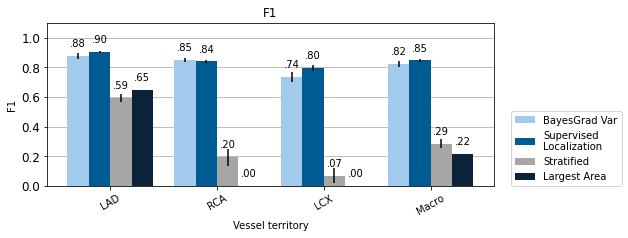

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), sharey=True)
plot_topK_predictions_by_k(performances, methods, regions, colors, stds=stds, total_width=0.8, title='F1', ax=ax, legend=True)
plt.savefig("../output/figures/top15_pred_supervised_f1_no_leading_0.png", dpi=300, bbox_inches='tight')

# Create top K prediction example figure 
- descriptive statistics for single vessel disease and example top K pred

study no: 773


,scar_lad,scar_rca,scar_lcx,ischemia_lad,ischemia_rca,ischemia_lcx
17,0,1,0,0,0,0


Probability of Abnormal: 0.88450044


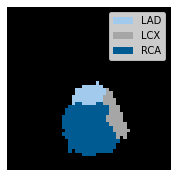

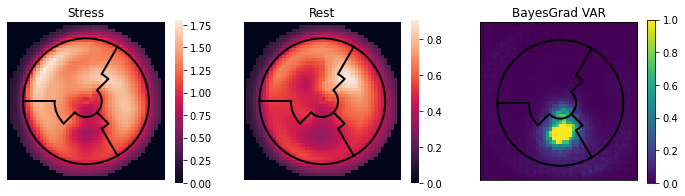

In [63]:
for sn in [773]:
    mask = study_nos == sn
    pp1 = X[mask]
    # pp_473.shape
    y_loc1 = y_loc[mask]
    prob1 = probabilities[mask]
    study_no1 = study_nos[mask]
    smap1 = s_maps['BG_VAR'][mask]

    fig, ax = plt.subplots(figsize=(4, 3))

    peu.pixels_to_vessel(smap1[0], 15, vessel_mask, importance='abs', plot=True, title=None, ax=ax, legend=True)
    plt.savefig(f'../output/figures/top15_study_no_{sn}.png', bbox_inches='tight')
    peu.display_saliency_maps({'BG_VAR': smap1},
                              polar_plots=pp1,
                              y_loc=y_loc1,
                              probabilities=prob1,
                              k=1,
                              method='BG_VAR',
                              study_nos=study_no1,
                              weighted=False,
                              savedir='../output/figures')

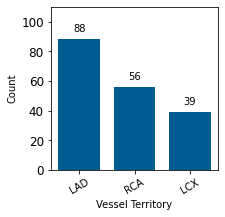

In [65]:
counts = pd.DataFrame(y_abn_loc[svd], columns=['LAD', 'RCA', 'LCX']).apply(np.sum, axis=0)

fix, ax = plt.subplots(figsize=(3, 3))

X_axis = np.arange(len(counts))
ax.set_xticks(X_axis)
ax.set_xticklabels(counts.index, rotation=30, ha='center')
ax.tick_params(axis='y', labelsize=12)
# plt.grid(axis='y')



ax.bar([0,1,2], counts, .75, color=np.array([0,91,147]) / 255)
for i, v in enumerate(counts):
    ax.text(i, v + 5, '{}'.format(v), ha='center')
    
ax.set_ylim(0, 110)
ax.set_xlabel('Vessel Territory')
ax.set_ylabel('Count')
plt.savefig(f'../output/figures/SVD_dist.png', bbox_inches='tight')

## Vessel Mask in MITRE colors for figure

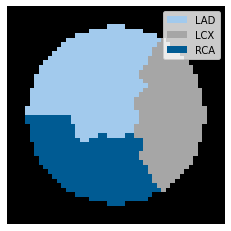

In [73]:
fig, ax = plt.subplots()
peu.pixels_to_vessel(smap1[0], 100, vessel_mask, plot=True, title='', ax=ax, legend=True)
plt.savefig('../output/figures/vessel_mask_MITRE.png')

## Vessel masks for each territory

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


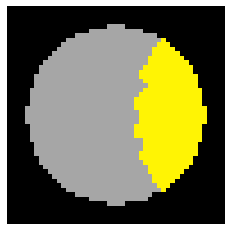

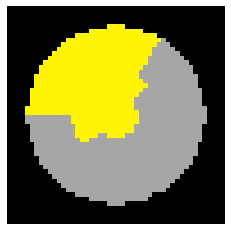

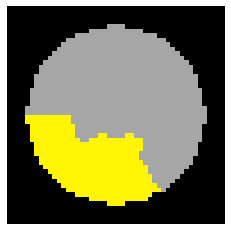

In [112]:
peu.plot_region(vessel_mask, lcx=True)
plt.savefig('../output/figures/vessel_mask_lcx.png')

peu.plot_region(vessel_mask, lad=True)
plt.savefig('../output/figures/vessel_mask_lad.png')

peu.plot_region(vessel_mask, rca=True)
plt.savefig('../output/figures/vessel_mask_rca.png')

## Figure 7 (Atypical attention map reviewed by physician)

study no: 4494


,scar_lad,scar_rca,scar_lcx,ischemia_lad,ischemia_rca,ischemia_lcx
88,0,0,0,0,0,1


Probability of Abnormal: 0.22406597


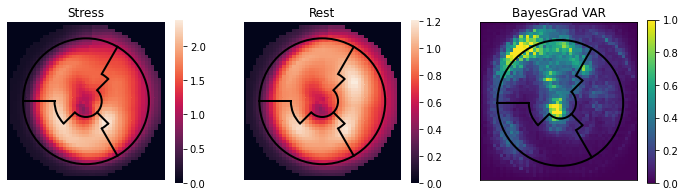

In [18]:
methods = ['BG_VAR']
split = 'test'
base_path = '../output/smaps_original'
model_alias = 'norm_abn_VGGDrop_abnormal_lr=0.0001_drop=0.3_reg=0.0_base_filters=128.0_stdscaler=0.0_vary=False_rotation=180.0_hflip=True_vflip=True_hshift=0.05_wshift=0.05_str_rst'

res = peu.load_saved_smaps(methods, split, base_path, model_alias)
s_maps, study_nos, probabilities = res['s_maps'], res['study_nos'], res['probabilities']
X, y_loc = peu.load_data_for_smaps(split, '../data')

sn_mask = study_nos == 4494
s_maps_sn = {'BG_VAR': s_maps['BG_VAR'][sn_mask]}

peu.display_saliency_maps(s_maps_sn,
                          polar_plots=X[sn_mask],
                          y_loc=y_loc[sn_mask],
                          probabilities=probabilities[sn_mask],
                          k=None,
                          method='BG_VAR',
                          study_nos=study_nos[sn_mask],
                          weighted=False,
                          savedir='../output/figures')